## Classification
### Stroke Prediction Dataset

#### Attribute Information:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [1]:
import pandas as pd
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import preprocessing 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import toad
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import dalex as dx
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


In [2]:
df = pd.read_csv(r'C:\Users\HP\Desktop\szkolne\5 rok\ml2\ML2-project\data\c1.csv')

list_dummies = ['ever_married', 'smoking_status', 'Residence_type', 'work_type', 'gender']
df = pd.get_dummies(df, columns=[var for var in list_dummies], drop_first=True)
df.drop(columns = ['id'], inplace=True)

### Data split

In [3]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

seed = 15
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

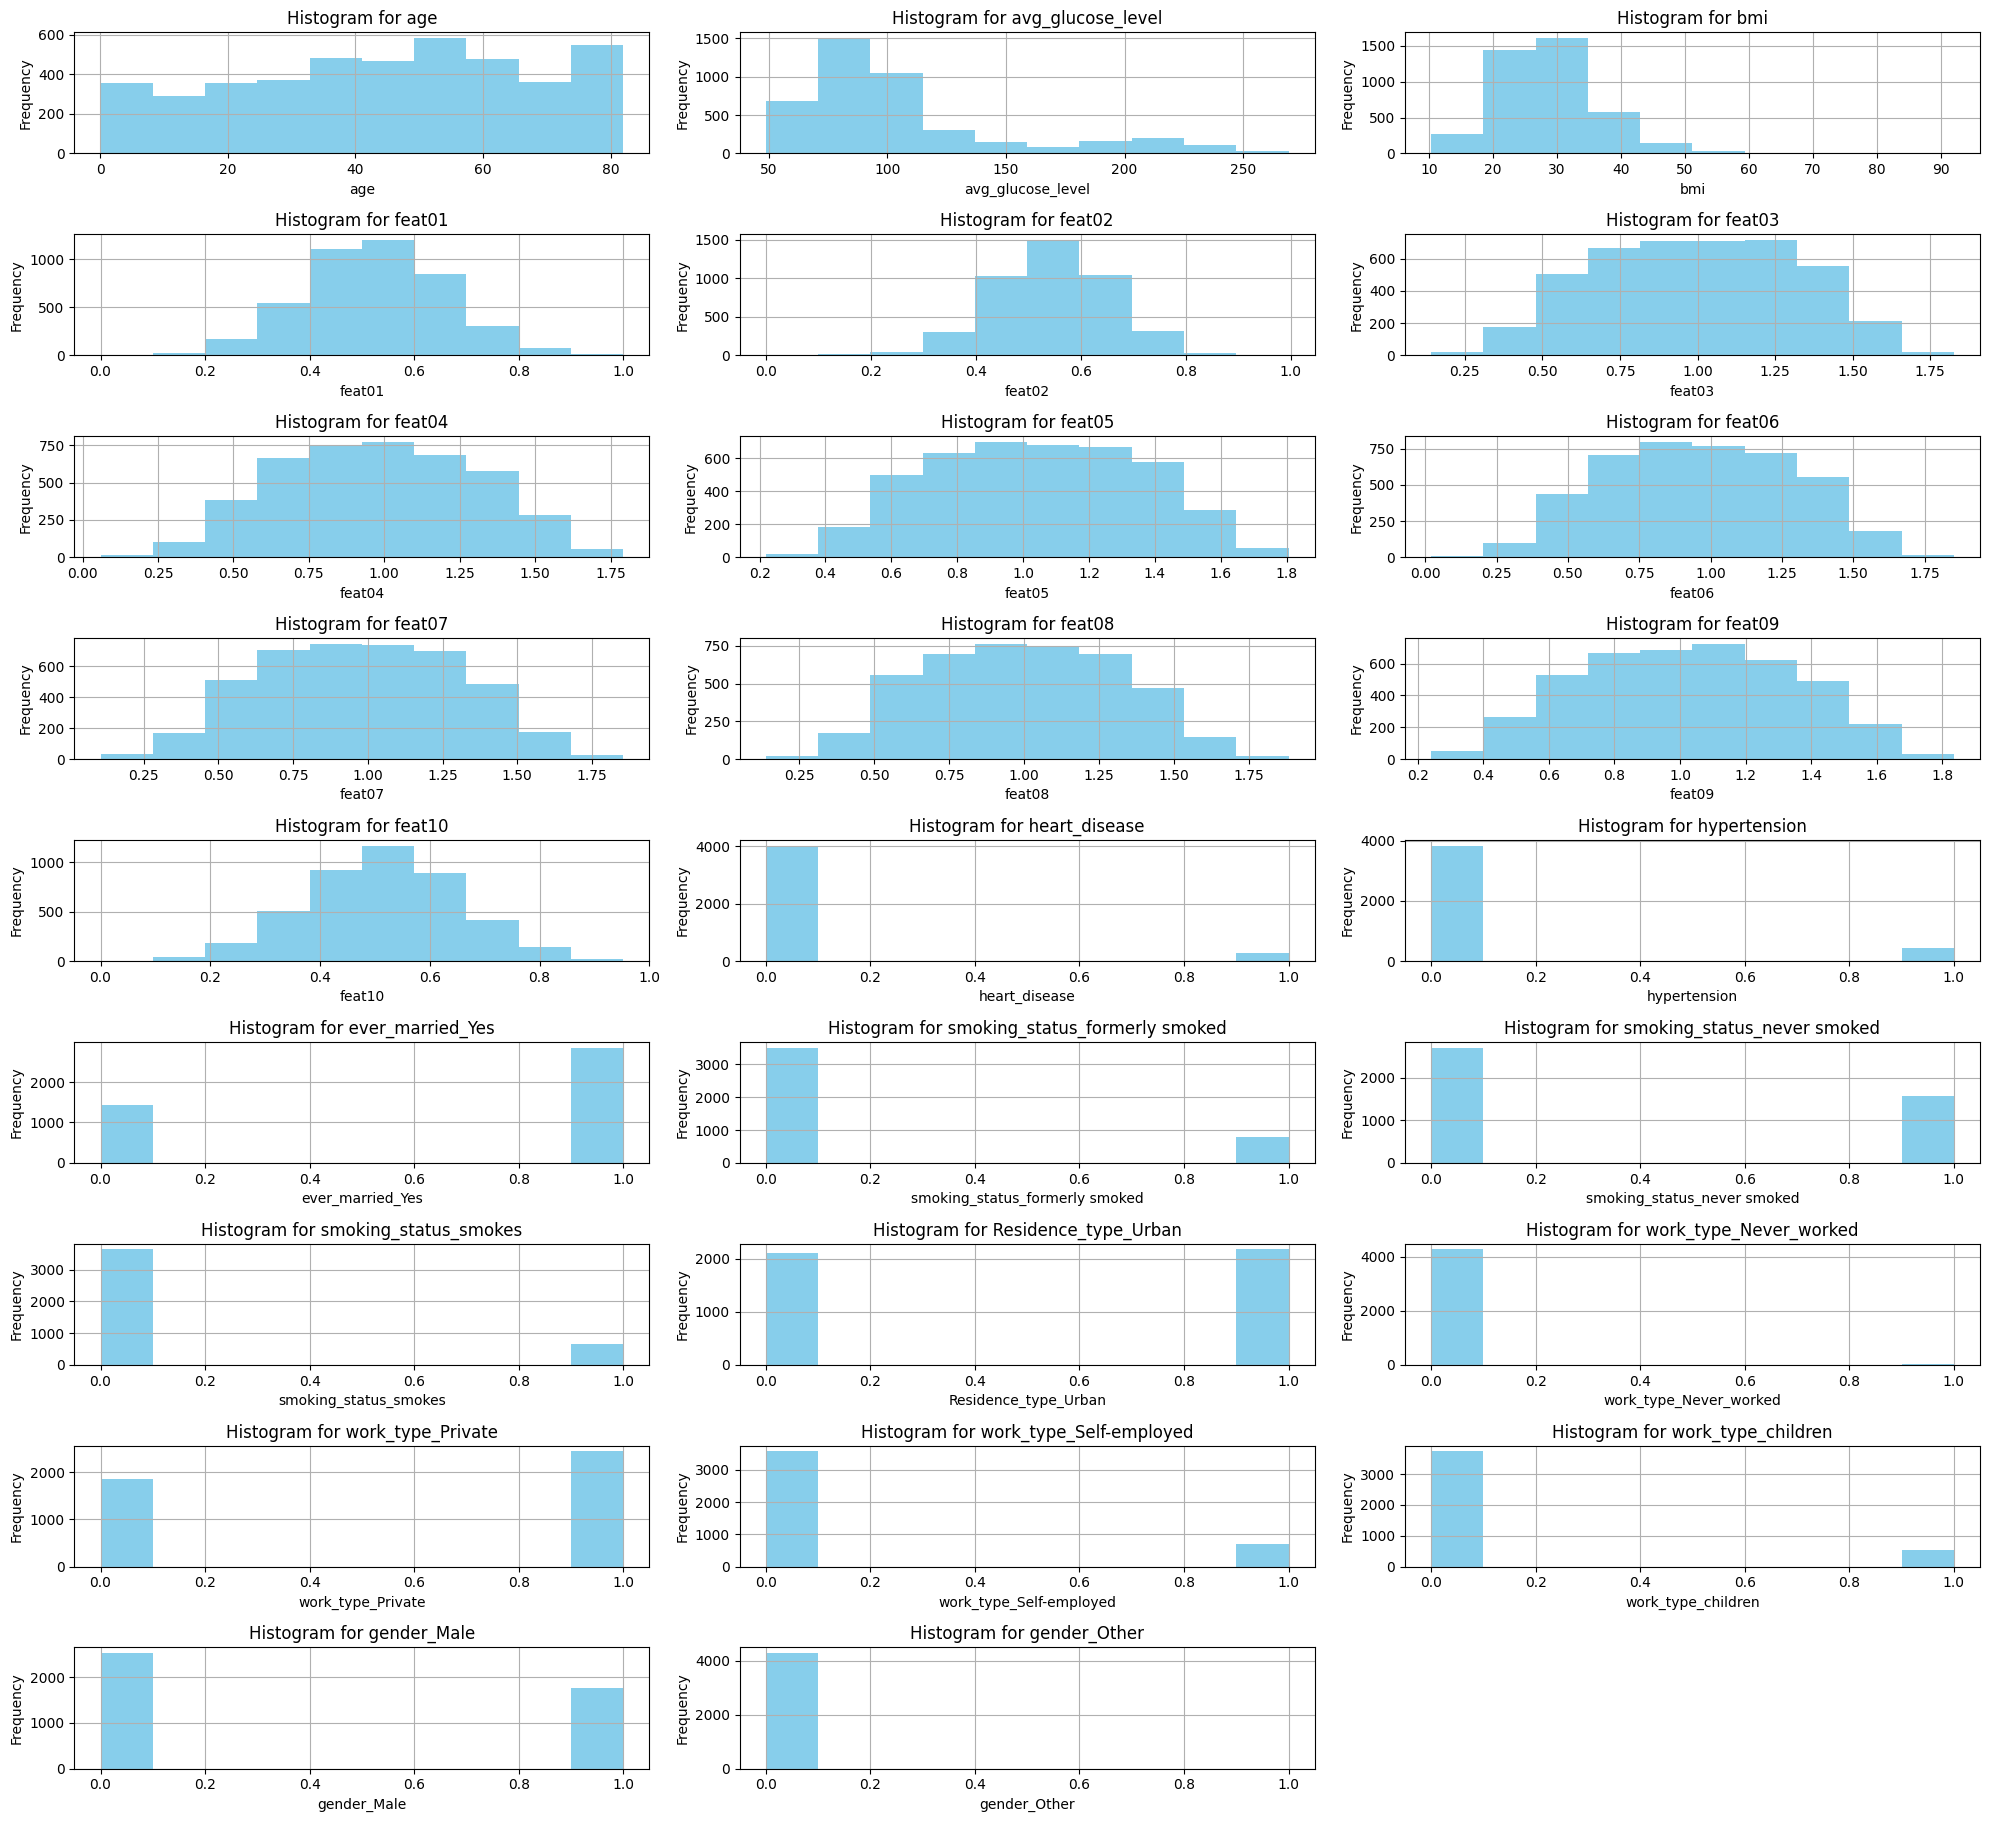

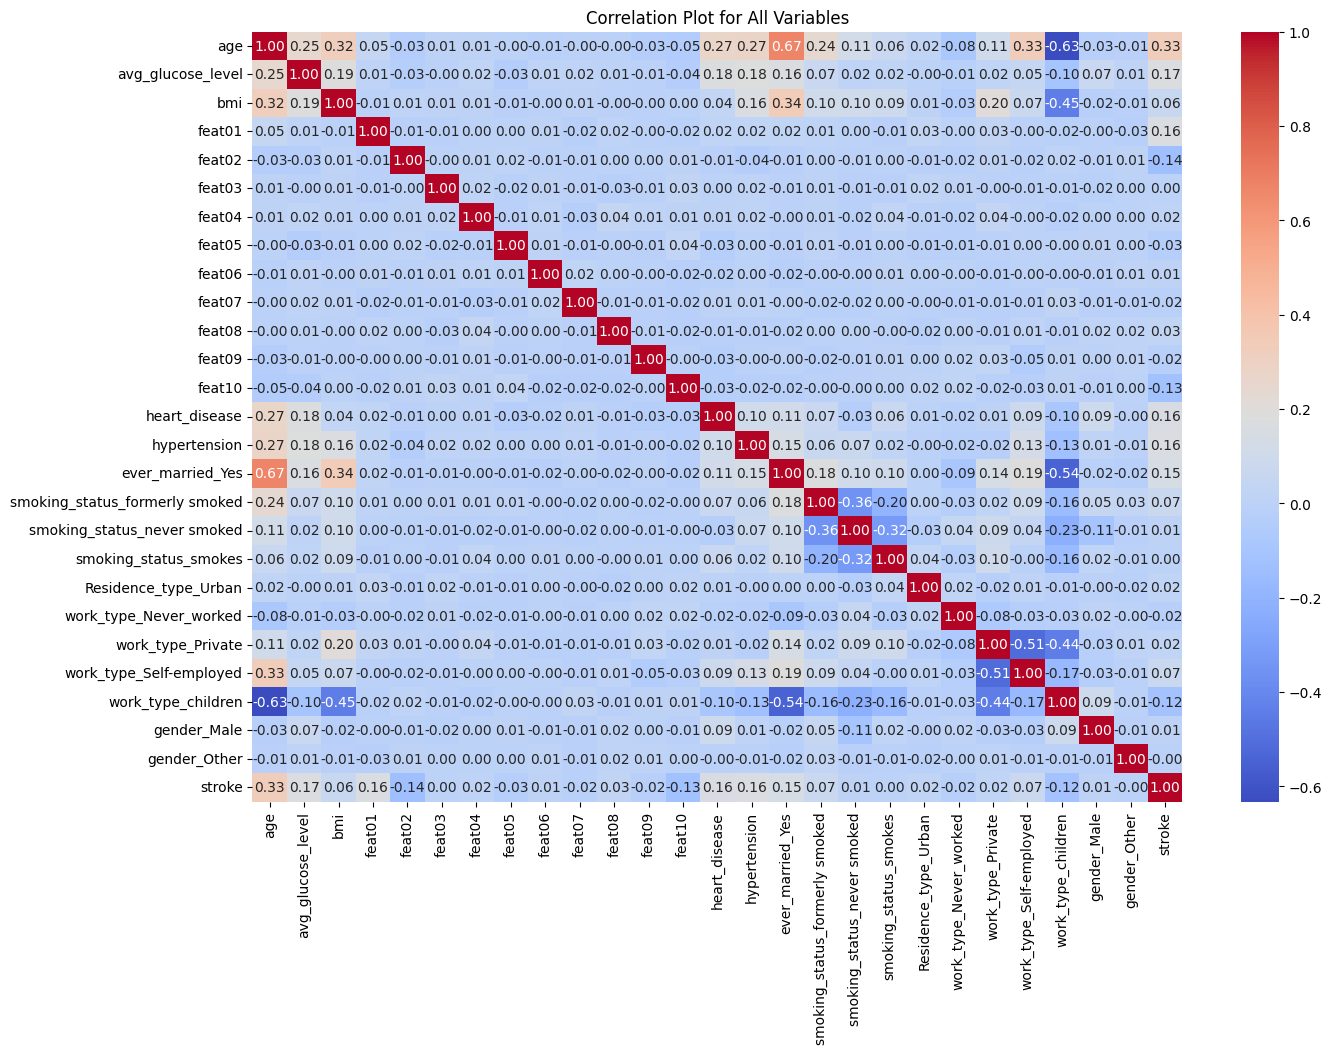

In [4]:
# Set up subplots with 2 columns and 7 rows
num_rows = 15
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot histograms for each variable on separate subplots
for i, variable in enumerate(X_train.columns):
    X_train[variable].hist(ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(X_train.columns), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


corr_train_df = pd.concat([X_train, y_train], axis = 1)

corr_matrix = corr_train_df.corr()
corr_matrix['stroke'].sort_values()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot for All Variables')
plt.show()


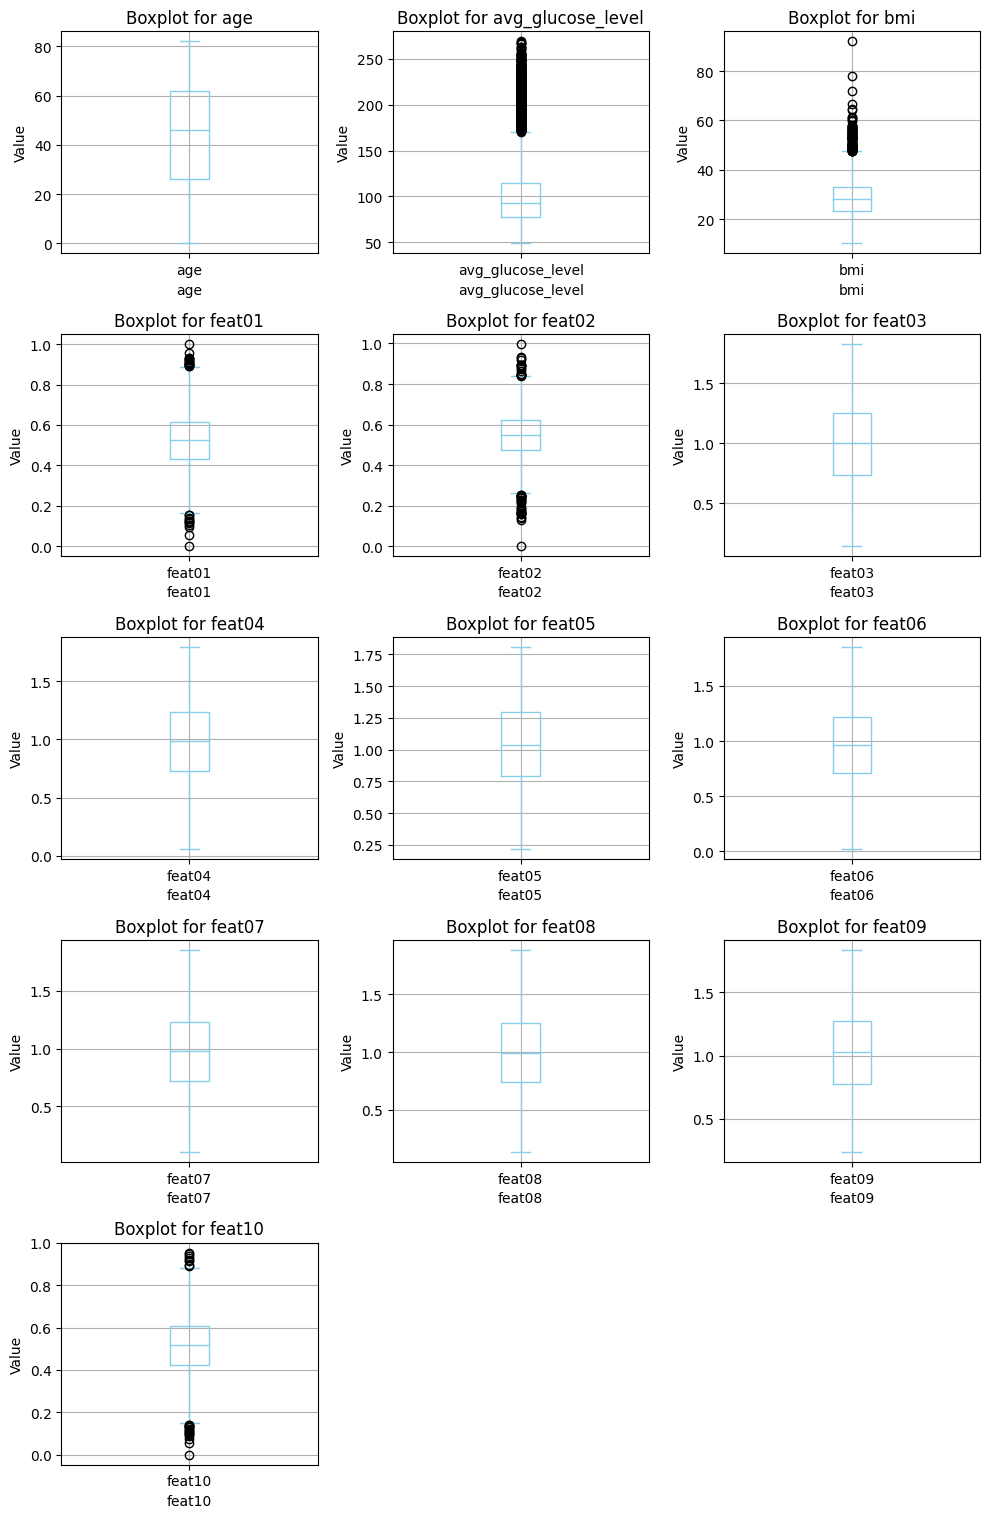

In [5]:
variables_to_plot = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Set up subplots with 2 columns and 7 rows
num_rows = 10
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(10, 30))


# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot boxplots for each variable on separate subplots
for i, variable in enumerate(variables_to_plot):
    X_train.boxplot(column=variable, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Value')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(variables_to_plot), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

# ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

## XGBoost with randomized search

In [6]:
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()


FFS_LGB_prec_full = SequentialFeatureSelector(
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=123),
    k_features=(1,26),
    forward=True,
    verbose=2,
    cv=3,
    scoring = 'roc_auc',
    n_jobs=-1).fit(X_train, y_train)

selected_features_full_xgb = FFS_LGB_prec_full.feature_names

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    7.2s finished

[2024-02-05 21:32:46] Features: 1/26 -- score: 0.8312838204356127[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.9s finished

[2024-02-05 21:32:49] Features: 2/26 -- score: 0.9012660808751427[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.6s finished

[2024-02-05 21:32:53] Features: 3/26 -- score: 0.9061037884903443[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    3.5s finished

[2024-02-05 21:32:56] Features: 4/26 -- score: 0.9065376604198815[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    3.7s finished



In [7]:
# selected_features_full_xgb = list(FFS_LGB_prec_full.k_feature_names_)
selected_features_full_xgb = ['age',
 'bmi',
 'hypertension',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other']

selected_feat = selected_features_full_xgb

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}
Test Accuracy: 0.9421641791044776


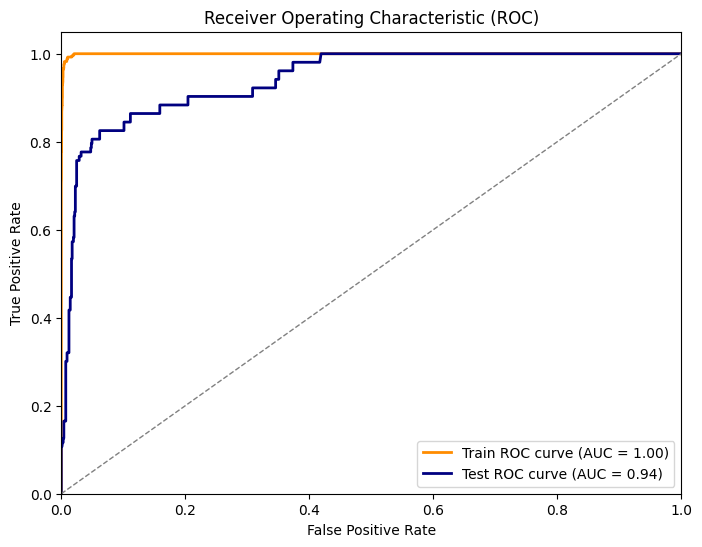

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

selected_feat = selected_features_full_xgb

scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

xgb_classifier = XGBClassifier()

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': np.arange(3, 10),
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='accuracy', 
    cv=3,  
    verbose=1,
    n_jobs=-1,  
    random_state=42
)


random_search.fit(X_train, y_train)


print("Best Parameters:", random_search.best_params_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)


y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [9]:
exp = dx.Explainer(best_model, X_train, y_train)
imp = exp.model_parts(type = "variable_importance")
# plt.plot(imp)

Preparation of a new explainer is initiated

  -> data              : 4287 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4287 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001FA442C60C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.81e-05, mean = 0.092, max = 0.978
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.725, mean = 0.000105, max = 0.768
  -> model_info        : package xgboost

A new explainer has been created!


In [10]:
imp
# imp.plot(max_vars=5)

,variable,dropout_loss,label
0,_full_model_,0.000772,XGBClassifier
1,gender_Other,0.000772,XGBClassifier
2,work_type_Never_worked,0.000772,XGBClassifier
3,smoking_status_smokes,0.003599,XGBClassifier
4,smoking_status_formerly smoked,0.005958,XGBClassifier
5,gender_Male,0.010446,XGBClassifier
6,hypertension,0.010899,XGBClassifier
7,smoking_status_never smoked,0.012811,XGBClassifier
8,bmi,0.152416,XGBClassifier
9,age,0.378763,XGBClassifier


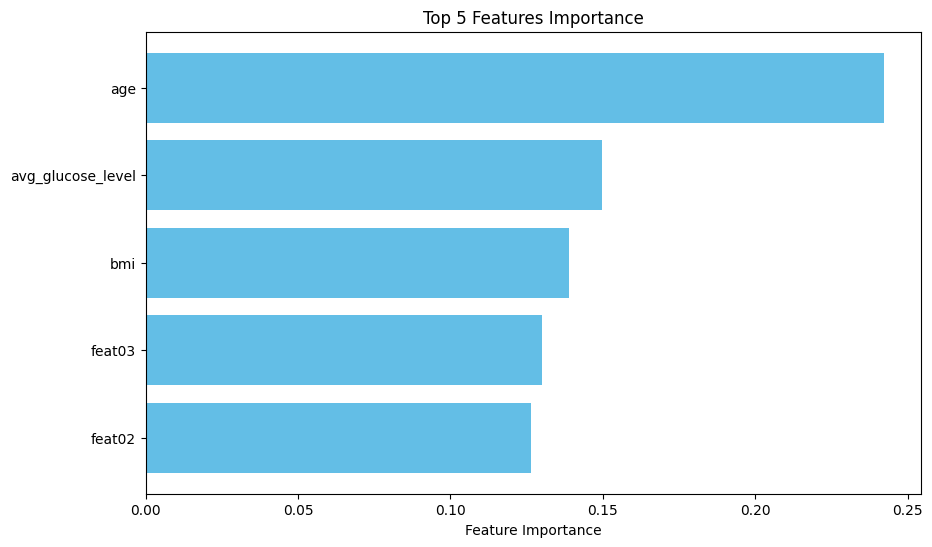

In [11]:

sorted_idx = best_model.feature_importances_.argsort()

# Select the last five elements
top_features_idx = sorted_idx[-5:]

# Plotting only the top five features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[top_features_idx], best_model.feature_importances_[top_features_idx], color = '#63bee6')
plt.xlabel('Feature Importance')
plt.title('Top 5 Features Importance')
plt.show()
# X.columns

In [12]:
mp = exp.model_performance(model_type = 'classification')
mp.result

,recall,precision,f1,accuracy,auc
XGBClassifier,0.941772,0.973822,0.957529,0.992302,0.999422


In [13]:
vi = exp.model_parts()
# pd.options.display.float_format = '{:.3f}'.format
# vi.result

# exp = dx.Explainer(model, X_train, y_train)
# y_test_pred = exp.predict_parts(X_test[0], type='break_down')

# vi = exp.model_parts()
# vi.result
pdp_num = exp.model_profile(type = 'partial', label="pdp")
ale_num = exp.model_profile(type = 'accumulated', label="ale")
pdp_num.plot(ale_num)

Calculating accumulated dependency: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


### Multi-Layer Perceptron

In [14]:
selected_features_full_xgb

['age',
 'bmi',
 'hypertension',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other']

(4287, 9)
(1072, 9)


<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast



c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Fitting 3 folds for each of 50 candidates, totalling 150 fits


<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast



Best Hyperparameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__early_stopping': False, 'classifier__hidden_layer_sizes': (100, 100), 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 746, 'classifier__solver': 'adam', 'classifier__validation_fraction': 0.3}
Best Balanced Accuracy: 0.5699678281406566


<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast



Accuracy: 89.65%
gini: 0.76%


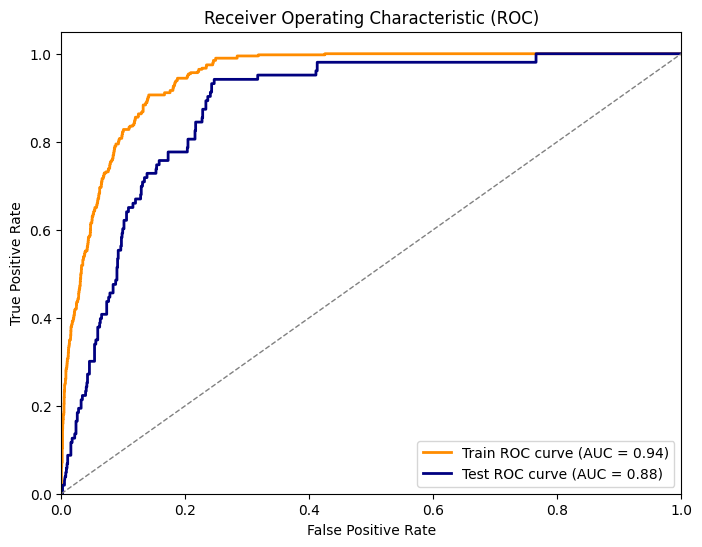

In [15]:
from scipy.stats import randint
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
selected_features_full_mlp = selected_features_full_xgb
X_train = X_train[selected_features_full_mlp]
X_test = X_test[selected_features_full_mlp]
numerical_features = ['age', 'bmi',]
# numerical_features.extend()
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = ['hypertension',
                        'smoking_status_formerly smoked',
                        'smoking_status_never smoked',
                        'smoking_status_smokes',
                        'work_type_Never_worked',
                        'gender_Male',
                        'gender_Other']



categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        # ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


classifier = MLPClassifier(random_state=0)

clf = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', classifier)])

print(X_train.shape)
print(X_test.shape)

clf.fit(X_train, y_train)


# # model.feature_importances_
# sorted_idx = clf.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()


# fit model no training data
param_dist = {
    'classifier__hidden_layer_sizes': [(50, ), (100, ), (150, ), (50, 50), (100, 100), (150, 150)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
    'classifier__max_iter': randint(200, 1000),  # Range from 200 to 1000
    'classifier__early_stopping': [True, False],
    'classifier__validation_fraction': [0.1, 0.2, 0.3]
}

# Create an MLPClassifier
classifier = MLPClassifier(random_state=0)

# Use the pipeline and include the classifier inside the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=3, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to find the best hyperparameters
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Balanced Accuracy:", best_score)

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = best_estimator.predict_proba(X_train)[:, 1]
y_test_prob = best_estimator.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
gini = 2*roc_auc_test-1
print("gini: %.2f%%" % (gini))
# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# classifier.fit(X_train, y_train)

## Random Forest Classifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()
imp = SimpleImputer(missing_values=np.nan, strategy='median')

X_train = imp.fit_transform(X_train)

FFS_LGB_prec_full = SequentialFeatureSelector(
    RandomForestClassifier(random_state=123),
    k_features=(1,20),
    forward=True,
    verbose=2,
    cv=3,
    scoring = 'roc_auc',
    n_jobs=-1).fit(X_train, y_train)
selected_features_rfe_no_bin = list(FFS_LGB_prec_full.k_feature_names_)
selected_features_rfe_no_bin


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   18.7s finished

[2024-02-05 21:37:40] Features: 1/20 -- score: 0.8286411796540918[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.4s finished

[2024-02-05 21:37:53] Features: 2/20 -- score: 0.8891020172050234[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.7s finished

[2024-02-05 21:38:08] Features: 3/20 -- score: 0.8966074770259098[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   19.6s finished

[2024-02-05 21:38:28] Features: 4/20 -- score: 0.9041063708712652[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.5s finished

[2024-02-05 21:38:46] Features: 5/20 -- score: 0.9090488622865034[Parallel(n

['0', '1', '2', '14', '15', '17', '18', '21', '24', '25']

(4287, 10)
(1072, 10)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 30, 'bootstrap': True}
Accuracy: 94.68%
gini:  0.8737463304177064


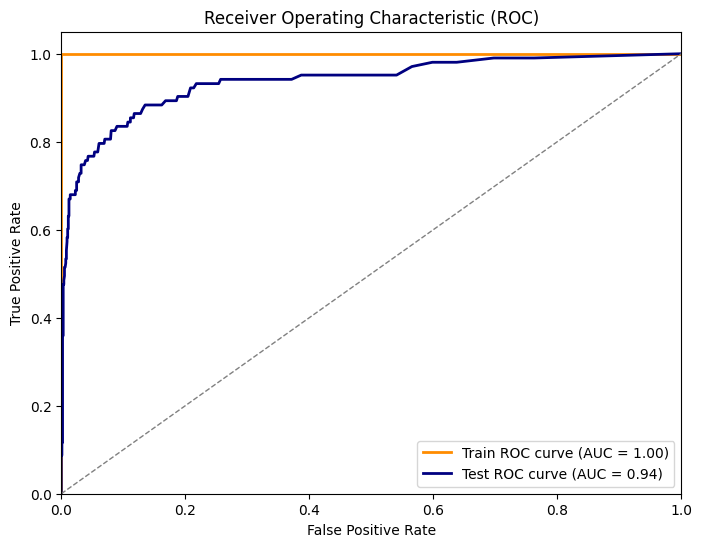

In [17]:
selected_features_full_rfe = list(map(int, selected_features_rfe_no_bin))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

X_train = X_train.iloc[:, selected_features_full_rfe]
X_test = X_test.iloc[:, selected_features_full_rfe]

imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train, X_test = imp.fit_transform(X_train), imp.fit_transform(X_test)



classifier = RandomForestClassifier()


print(X_train.shape)
print(X_test.shape)

# classifier.fit(X_train, y_train)


param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': np.arange(3, 10),
    'max_depth': [None, 5, 7, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    classifier,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='roc_auc', 
    cv=3,  
    verbose=1,
    n_jobs=-1,  
    random_state=42
)


random_search.fit(X_train, y_train)


print("Best Parameters:", random_search.best_params_)


best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


# fit model no training data


# y_pred = classifier.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = best_model.predict_proba(X_train)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

gini = 2*roc_auc_test-1
print('gini: ',gini)
# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Neural Networks

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
vars_to_bin = ['age','avg_glucose_level', 'bmi', 'feat05']

for var in vars_to_bin:    
    X_train[var] = X_train[var].fillna(X_train[var].median())
    quantiles = np.percentile(X_train[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_train[var+'_group'] = pd.cut(X_train[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_train =  X_train.drop([var], axis=1)

    
X_train = pd.get_dummies(X_train, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_train.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_train.rename(columns={col: new_col_name}, inplace=True)

X_train.head()


for var in vars_to_bin:    
    X_test[var] = X_test[var].fillna(X_test[var].median())
    quantiles = np.percentile(X_test[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_test[var+'_group'] = pd.cut(X_test[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_test =  X_test.drop([var], axis=1)

    
X_test = pd.get_dummies(X_test, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_test.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_test.rename(columns={col: new_col_name}, inplace=True)

X_test.head()

[8.0e-02 2.6e+01 4.6e+01 6.2e+01 8.2e+01]
[ 48.78  77.14  92.22 114.46 269.12]
[10.3 23.8 28.  32.8 92. ]
[0.21886148 0.79518938 1.03853078 1.29257767 1.80572623]
[ 0.24 26.   46.   62.   82.  ]
[ 55.23    77.9825  92.345  118.92   271.74  ]
[13.2   24.4   28.7   32.825 97.6  ]
[0.28989827 0.82402106 1.06406014 1.30644424 1.79666385]


,feat01,feat02,feat03,feat04,feat06,feat07,feat08,feat09,feat10,heart_disease,...,age_group_3,avg_glucose_level_group_1,avg_glucose_level_group_2,avg_glucose_level_group_3,bmi_group_1,bmi_group_2,bmi_group_3,feat05_group_1,feat05_group_2,feat05_group_3
3790,0.479357,0.468511,0.875598,1.193794,0.446517,0.748220,1.023412,0.956672,0.686742,0,...,0,0,1,0,0,0,0,0,1,0
4104,0.778167,0.612455,0.724449,1.152877,1.554044,1.199502,0.994388,0.488902,0.699923,0,...,0,0,1,0,0,0,0,1,0,0
1329,0.619608,0.329020,1.694285,0.393456,1.115212,1.010597,0.654167,1.637885,0.650925,0,...,0,0,0,0,1,0,0,0,0,1
1530,0.642394,0.508069,1.376599,0.549300,0.369053,0.651213,1.002546,1.454605,0.654388,0,...,0,0,0,0,0,1,0,0,0,1
1595,0.553066,0.482170,0.631171,1.320802,0.816885,1.160169,1.323103,1.379332,0.485783,0,...,0,0,0,0,0,0,0,0,0,1


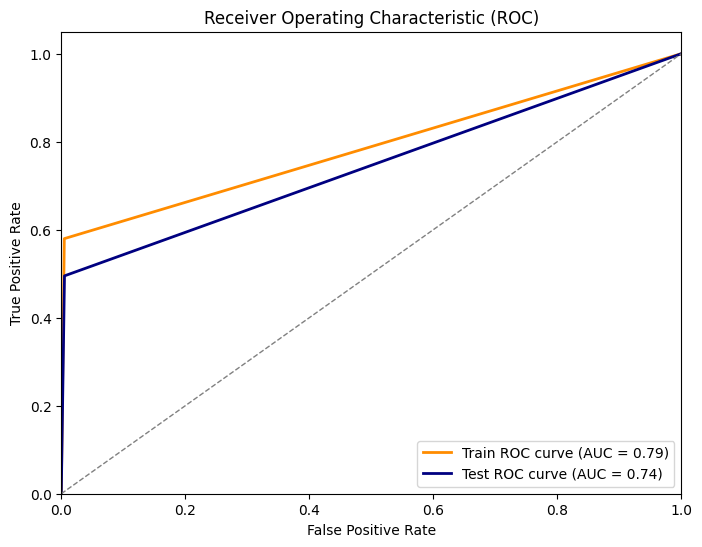

In [19]:
from keras import backend 
# from backend import floatx


def create_model():
 # create model
   model = Sequential()
   model.add(Dense(64,
                  input_shape=(X_train.shape[1:]),
                  activation='relu', name='dense_1'))

   # 3. second hidden layer, each with 128 units (neurons).
   model.add(Dense(128, activation='relu', name='dense_2'))

   # 4. The network ends with a single unit and no activation (it will be a linear layer).
   # This is a typical setup for scalar regression.
   model.add(Dense(1, activation='linear', name='dense_output'))

# Compile model
   model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[tf.keras.metrics.AUC()])
   return model
model = KerasClassifier(model=create_model, verbose=0, epochs = 50, batch_size=25)
model.fit(X_train, y_train)

y_train_prob=model.predict(X_train)
# y_train_prob = classifier.predict_proba(X_train)[:, 1]
y_test_prob = y_pred

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Stacking

Stacked Model Accuracy: 0.9188432835820896


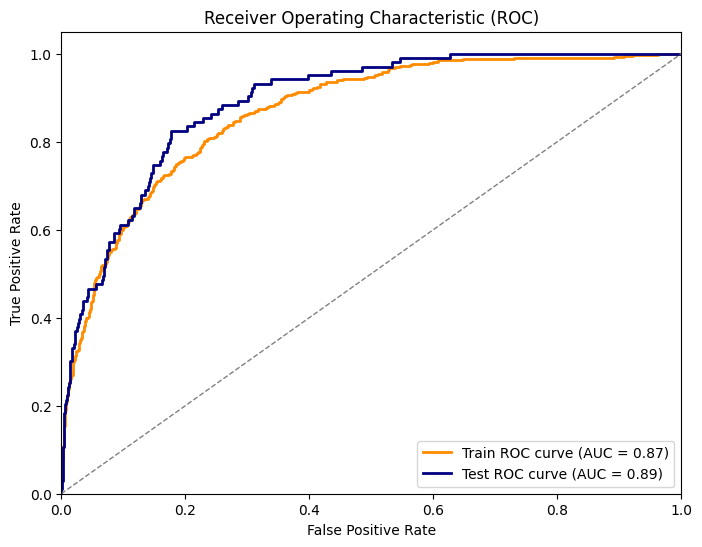

In [20]:
rf_model = RandomForestClassifier( random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
rf_predictions = cross_val_predict(rf_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
gb_predictions = cross_val_predict(gb_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

stacking_dataset = {
    'RandomForest': rf_predictions,
    'GradientBoosting': gb_predictions
}

stacking_X_train = pd.DataFrame(stacking_dataset)

meta_model = LogisticRegression()
meta_model.fit(stacking_X_train, y_train)
rf_test_predictions = rf_model.predict_proba(X_test)[:, 1]
gb_test_predictions = gb_model.predict_proba(X_test)[:, 1]

stacking_dataset_test = {
    'RandomForest': rf_test_predictions,
    'GradientBoosting': gb_test_predictions
}

stacking_X_test = pd.DataFrame(stacking_dataset_test)

final_predictions = meta_model.predict(stacking_X_test)
accuracy = accuracy_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, final_predictions)
print(f"Stacked Model Accuracy: {accuracy}")

y_train_prob = meta_model.predict_proba(stacking_X_train)[:, 1]
y_test_prob = meta_model.predict_proba(stacking_X_test)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Summary

To summarize, the best result on the testing set has been obtained by using Random Forest Classifier. Very similar to the best estimator was the XGBoost Classifier, which also obtained a very good result on the testing set. The stacking classifier had even better results on train than on the test set, which is very interesting as well. The classic Neural Networks' performance was definitely the worst out of all the models used, but the Multi-Layer Perceptron did much better, so in terms of neural networks usage we propose to use MLP. 

When choosing the best model, a couple of factors are important. The best performance was obtained for Random Forest, but it sometimes can take longer time to run than XGBoost. Also, for XGBoost the data does not have to be prepared like for Random Forest or MLP. The data used in this project was not very big to notice the difference in the running time. Hence, the algorithm chosen to be the best in this project is Random Forest Classifier.